Topic: generative classification

In [1]:
import sklearn
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn import metrics
from astroML.utils import completeness_contamination
from sklearn.metrics import roc_curve

from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis as QDA
from astroML.classification import GMMBayes
from sklearn.neighbors import KNeighborsClassifier

import pandas as pd
import numpy as np
import scipy.stats
import pylab as plt
from matplotlib import pyplot as plt
from scipy import stats
import random
import math
import seaborn as sns

We want to classify galaxies vs quasars in the Sloan Digital Sky Survey. In our dataset we have the intensity of the radiation in each color band.

In [2]:
import pandas as pd
data = pd.read_csv("galaxyquasar.csv")
data

,u,g,r,i,z,class,z1,zerr
0,18.97213,18.53676,18.58280,18.34936,18.29215,QSO,0.522819,0.000155
1,19.24592,17.47646,16.47817,16.04472,15.68851,GALAXY,0.122846,0.000028
2,19.43536,17.70268,16.91565,16.58327,16.39128,GALAXY,0.000000,0.000000
3,19.31626,18.18312,17.39591,16.94549,16.65395,GALAXY,0.147435,0.000009
4,19.28828,19.11188,18.88937,18.80013,18.49183,QSO,2.011455,0.000631
...,...,...,...,...,...,...,...,...
49995,19.37295,18.12382,17.39886,16.98503,16.70585,GALAXY,0.113016,0.000011
49996,18.52021,16.88262,16.03280,15.56884,15.22454,GALAXY,0.085063,0.000014
49997,18.62718,17.30876,16.87371,16.62399,16.42296,GALAXY,0.054429,0.000008
49998,19.55140,18.27711,17.62101,17.21947,17.03347,GALAXY,0.112571,0.000009


In [3]:
print('Fraction of quasars: '+str(len(data['class'][data['class'] == 'QSO'])/len(data['class'])))
print('Fraction of galaxies: '+str(len(data['class'][data['class'] == 'GALAXY'])/len(data['class'])))

Fraction of quasars: 0.14268
Fraction of galaxies: 0.85732


Only $14\%$ of the samples is a quasar. We want to be sure to correctly identify all (or most) of them: therefore, we want to maximise the completeness, at the cost of a slightly higher contamination.

First, we split our data in training and test set. Then, we create arrays for the $(u-g)$, $(g-r)$, $(r-i)$ and $(i-z)$ colors. We also create an array with the class labels where $galaxy=0$ and $quasar=1$.

In [4]:
X_train, X_test = train_test_split(data,train_size=0.8,random_state=42)

In [5]:
u_g_train = (X_train['u']-X_train['g']).to_numpy()
g_r_train = (X_train['g']-X_train['r']).to_numpy()
r_i_train = (X_train['r']-X_train['i']).to_numpy()
i_z_train = (X_train['i']-X_train['z']).to_numpy()
classes_train = (X_train['class']).to_numpy()
classes_train[classes_train == 'QSO'] = 1
classes_train[classes_train == 'GALAXY'] = 0
classes_train = np.float64(classes_train)

u_g_test = (X_test['u']-X_test['g']).to_numpy()
g_r_test = (X_test['g']-X_test['r']).to_numpy()
r_i_test = (X_test['r']-X_test['i']).to_numpy()
i_z_test = (X_test['i']-X_test['z']).to_numpy()
classes_test = (X_test['class']).to_numpy()
classes_test[classes_test == 'QSO'] = 1
classes_test[classes_test == 'GALAXY'] = 0
classes_test = np.float64(classes_test)

In [6]:
matrix_train = np.column_stack((u_g_train,g_r_train,r_i_train,i_z_train))
matrix_test = np.column_stack((u_g_test,g_r_test,r_i_test,i_z_test))

# Gaussian Naive Bayes

Let's compute the completeness and the contamination of the test set as a function of the number of features that we use to train the algorithm.

In [7]:
gnb = GaussianNB()

completeness = []
contamination = []

for i in range(matrix_train.shape[1]):
    gnb.fit(matrix_train[:,:i+1],classes_train)
    predicted_labels_gnb = gnb.predict(matrix_test[:,:i+1])
    completeness.append(completeness_contamination(predicted_labels_gnb, classes_test)[0])
    contamination.append(completeness_contamination(predicted_labels_gnb, classes_test)[1])

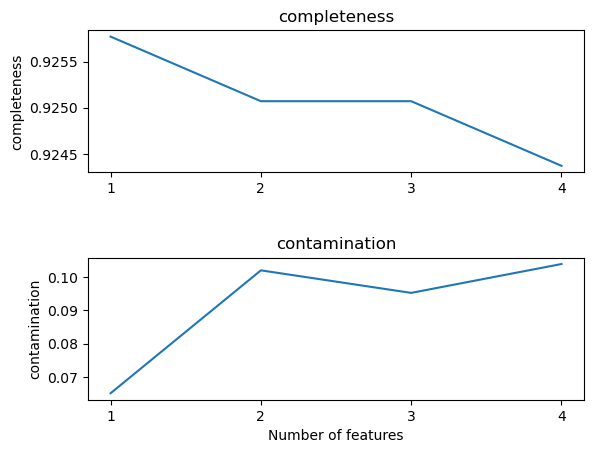

In [8]:
x = [1,2,3,4]
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.6)

axes[0].plot(x,completeness)
axes[0].set_title('completeness')
axes[0].set_ylabel('completeness')
axes[0].set_xticks(x)

axes[1].plot(x,contamination)
axes[1].set_title('contamination')
axes[1].set_ylabel('contamination')
axes[1].set_xlabel('Number of features')
axes[1].set_xticks(x)

plt.show()

Using only the first component gives us the highest completeness and the lowest contamination.

In [9]:
print('completeness = ', completeness[0])
print('contamination = ', contamination[0])
completeness_GNB = completeness[0]

completeness =  0.9257703081232493
contamination =  0.06506364922206506


# Linear discriminant analysis

In [10]:
lda = LDA()

completeness = []
contamination = []

for i in range(matrix_train.shape[1]):
    lda.fit(matrix_train[:,:i+1],classes_train)
    predicted_labels_lda = lda.predict(matrix_test[:,:i+1])
    completeness.append(completeness_contamination(predicted_labels_lda, classes_test)[0])
    contamination.append(completeness_contamination(predicted_labels_lda, classes_test)[1])

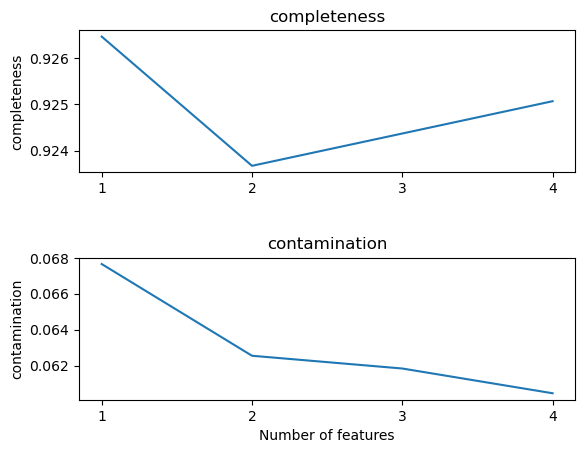

In [11]:
x = [1,2,3,4]
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.6)

axes[0].plot(x,completeness)
axes[0].set_title('completeness')
axes[0].set_ylabel('completeness')
axes[0].set_xticks(x)

axes[1].plot(x,contamination)
axes[1].set_title('contamination')
axes[1].set_ylabel('contamination')
axes[1].set_xlabel('Number of features')
axes[1].set_xticks(x)

plt.show()

In [12]:
print('completeness = ', completeness[0])
print('contamination = ', contamination[0])
completeness_LDA = completeness[0]

completeness =  0.9264705882352942
contamination =  0.06765327695560254


# Quadratic disciminant analysis

In [13]:
qda = QDA()

completeness = []
contamination = []

for i in range(matrix_train.shape[1]):
    qda.fit(matrix_train[:,:i+1],classes_train)
    predicted_labels_qda = qda.predict(matrix_test[:,:i+1])
    completeness.append(completeness_contamination(predicted_labels_qda, classes_test)[0])
    contamination.append(completeness_contamination(predicted_labels_qda, classes_test)[1])

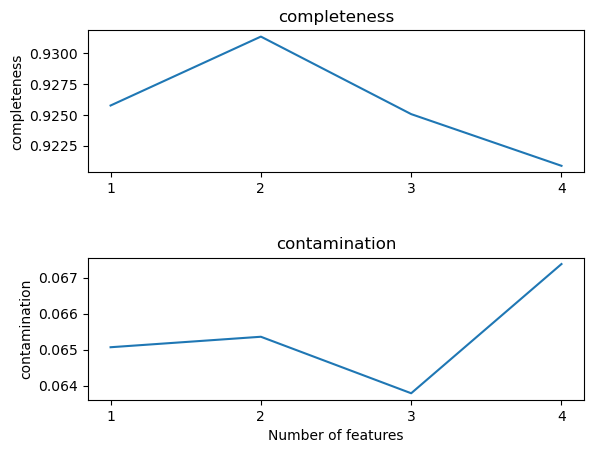

In [14]:
x = [1,2,3,4]
fig, axes = plt.subplots(2,1)
fig.subplots_adjust(hspace=0.6)

axes[0].plot(x,completeness)
axes[0].set_title('completeness')
axes[0].set_ylabel('completeness')
axes[0].set_xticks(x)

axes[1].plot(x,contamination)
axes[1].set_title('contamination')
axes[1].set_ylabel('contamination')
axes[1].set_xlabel('Number of features')
axes[1].set_xticks(x)

plt.show()

In [15]:
print('completeness = ', completeness[1])
print('contamination = ', contamination[1])
completeness_QDA = completeness[1]

completeness =  0.9313725490196079
contamination =  0.06535488404778636


# GMM Bayes

In [16]:
def cross_gmm(n_components,n_features):
    model = GMMBayes(n_components=n_components)
    kf = KFold(n_splits=5,shuffle=True,random_state=42)

    completeness = []
    contamination = []
    
    for train, test in kf.split(matrix_train):
        model.fit(matrix_train[train,:n_features],classes_train[train])
        y_pred = model.predict(matrix_train[test,:n_features])
        c1, c2 = completeness_contamination(y_pred, classes_train[test])
        completeness.append(c1)
        contamination.append(c2)

    return np.sum(completeness)/len(completeness), np.sum(contamination)/len(contamination)

In [17]:
components = np.array([5,10,15])
features = np.arange(1,5,1)

completeness = []
contamination = []
param = []

for i in components:
    for j in features:
        param.append([i,j])
        c1, c2 = cross_gmm(i,j)
        completeness.append(c1)
        contamination.append(c2)

In [18]:
completeness = np.array(completeness)
contamination = np.array(contamination)
param = np.array(param)
print('Highest completeness = ', np.max(completeness))
completeness_GMMB = np.max(completeness)
print('components: ', param[completeness==np.max(completeness)][0,0])
print('features: ', param[completeness==np.max(completeness)][0,1])
print('contamination = ', contamination[completeness==np.max(completeness)][0])

Highest completeness =  0.9375541637825553
components:  15
features:  4
contamination =  0.046615685009464156


# K-Nearest neighbors

In [19]:
def cross_kn(n_neighbors,n_features):
    model = KNeighborsClassifier(n_neighbors=n_neighbors)
    kf = KFold(n_splits=5,shuffle=True,random_state=42)

    completeness = []
    contamination = []
    
    for train, test in kf.split(matrix_train):
        model.fit(matrix_train[train,:n_features],classes_train[train])
        y_pred = model.predict(matrix_train[test,:n_features])
        c1, c2 = completeness_contamination(y_pred, classes_train[test])
        completeness.append(c1)
        contamination.append(c2)

    return np.sum(completeness)/len(completeness), np.sum(contamination)/len(contamination)

In [20]:
neighbors = np.array([5,10,15])
features = np.arange(1,5,1)

completeness = []
contamination = []
param = []

for i in neighbors:
    for j in features:
        param.append([i,j])
        c1, c2 = cross_kn(i,j)
        completeness.append(c1)
        contamination.append(c2)

In [21]:
completeness = np.array(completeness)
contamination = np.array(contamination)
param = np.array(param)
print('Highest completeness = ', np.max(completeness))
completeness_KNC = np.max(completeness)
print('components: ', param[completeness==np.max(completeness)][0,0])
print('features: ', param[completeness==np.max(completeness)][0,1])
print('contamination = ', contamination[completeness==np.max(completeness)][0])

Highest completeness =  0.9405784675511099
components:  5
features:  4
contamination =  0.04054403106770286


# ROC curves

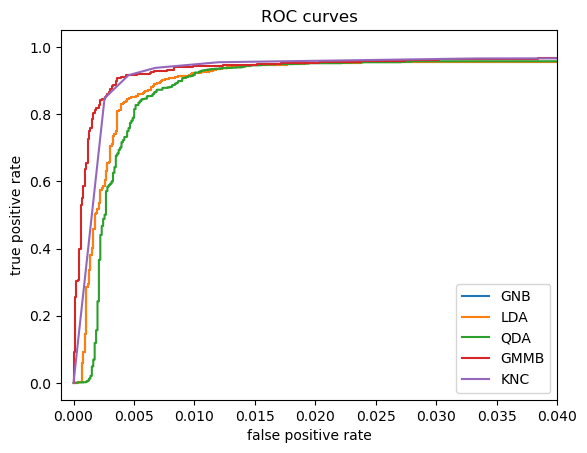

In [22]:
gnb = GaussianNB()
gnb.fit(matrix_train[:,:1],classes_train)
scores = gnb.predict_proba(matrix_test[:,:1])[:,1]
fpr, tpr, thresholds = metrics.roc_curve(classes_test, scores)
plt.plot(fpr,tpr,label= 'GNB')

lda = LDA()
lda.fit(matrix_train[:,:1],classes_train)
scores = lda.predict_proba(matrix_test[:,:1])[:,1]
fpr, tpr, thresholds = metrics.roc_curve(classes_test, scores)
plt.plot(fpr,tpr,label= 'LDA')

qda = QDA()
qda.fit(matrix_train[:,:2],classes_train)
scores = qda.predict_proba(matrix_test[:,:2])[:,1]
fpr, tpr, thresholds = metrics.roc_curve(classes_test, scores)
plt.plot(fpr,tpr,label= 'QDA')

gmmb = GMMBayes(15)
gmmb.fit(matrix_train,classes_train)
scores = gmmb.predict_proba(matrix_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(classes_test, scores)
plt.plot(fpr,tpr,label= 'GMMB')

knc = KNeighborsClassifier(5)
knc.fit(matrix_train,classes_train)
scores = knc.predict_proba(matrix_test)[:,1]
fpr, tpr, thresholds = metrics.roc_curve(classes_test, scores)
plt.plot(fpr,tpr,label= 'KNC')

plt.xlim(-0.001,0.04)
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.title('ROC curves')
plt.legend()
plt.show()

In [23]:
print('Completeness')
print('GNB', completeness_GNB)
print('LDA', completeness_LDA)
print('QDA', completeness_QDA)
print('GMMB', completeness_GMMB)
print('KNC', completeness_KNC)

Completeness
GNB 0.9257703081232493
LDA 0.9264705882352942
QDA 0.9313725490196079
GMMB 0.9375541637825553
KNC 0.9405784675511099
